In [71]:
%matplotlib inline
import matplotlib as mpl
#from matplotlib import pylab as plot
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import collections

import pandas as pd
import numpy as np
#import tensorflow.compat.v2 as tf
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import bijectors as tfb

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

#tf.enable_v2_behavior()

In [72]:
raw_data = pd.read_csv('C:/Users/amaur/Documents/Data_science/Bayesian_TS/pageviews-20190101-20201110.csv')
raw_data.head()

,Date,Vacation
0,2019-01-01,247
1,2019-01-02,358
2,2019-01-03,400
3,2019-01-04,338
4,2019-01-05,276


## Data Exploration

In [73]:
print(raw_data.describe())
print(raw_data.dtypes)

         Vacation
count  680.000000
mean   290.276471
std     83.027774
min    120.000000
25%    230.750000
50%    288.500000
75%    344.000000
max    756.000000
Date        object
Vacation     int64
dtype: object


In [74]:
raw_data.isna().count()

Date        680
Vacation    680
dtype: int64

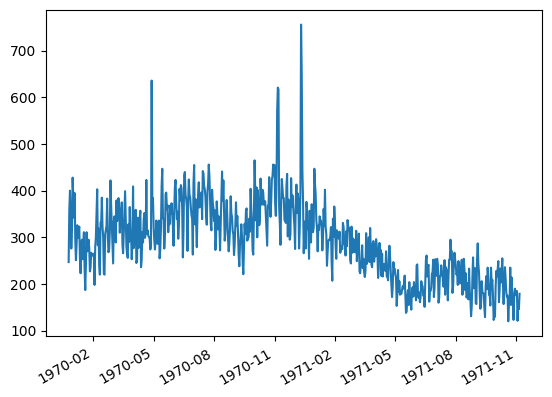

In [75]:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=91))
plt.plot(raw_data.Date, raw_data.Vacation)
plt.gcf().autofmt_xdate()
plt.show()

### Maybe we want to control for outliers so let us log the data (here smoothing for seasonal variation our tempering outliers is not important as we search for a change in trend rather thant predicting or detecting anomalies)

In [76]:
raw_data['log_vacation'] = np.log(raw_data['Vacation'])

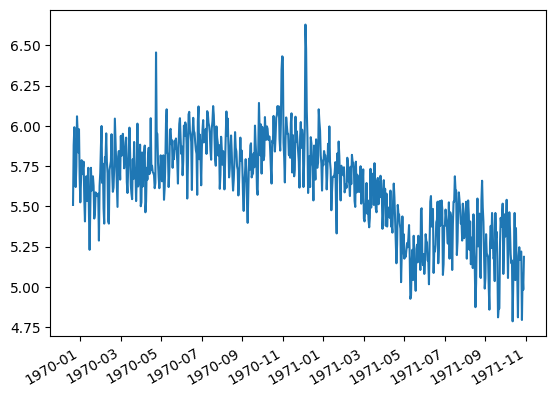

In [77]:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=61))
plt.plot(raw_data.Date, raw_data.log_vacation)
plt.gcf().autofmt_xdate()
plt.show()

## The Data Generating Process
Here we are facing a count per day, which fits a classical poisson distribution (so clearly the posterior distribution should be of this family). It is the value of the unique parameter defining the poisson distribution that is going to change pre and post covid.
It is changing because there is a change in the GDP after covid arrived (less purchasing power, less possibility of movement ...) which makes in hazardous to model our demand for vacation the same way.

In [78]:
raw_data['Date'] = pd.to_datetime(raw_data['Date'])

# Calculate min and max date
min_date = raw_data['Date'].min()
max_date = raw_data['Date'].max()

# Generate weekly interval using pandas date_range
daily_dates = pd.date_range(start=min_date, end=max_date, freq='D')

# Convert the pandas DatetimeIndex to a numpy.ndarray with datetime64 type
vacation_dates = daily_dates.to_numpy(dtype=np.datetime64)
vacation_dates = vacation_dates.astype('datetime64[D]')

## date printing formater 
vacation_loc = mdates.DayLocator(interval=91)
vacation_fmt = mdates.DateFormatter('%Y-%m')

## Number of forcasting steps (half a year)
num_forecast_steps = 31

## Formating time serie data
serial_data = raw_data.log_vacation.tolist()
serial_data = np.array(serial_data).astype(np.float32)
## Training_data
training_data = serial_data[:-num_forecast_steps]

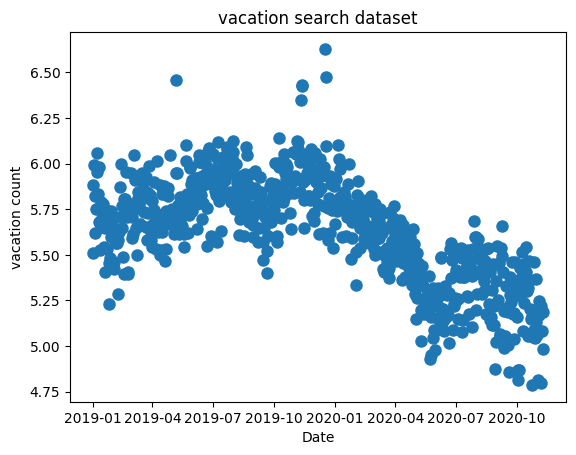

In [79]:
plt.plot(vacation_dates, serial_data, 'o', markersize=8);
plt.ylabel('vacation count')
plt.xlabel('Date')
plt.title('vacation search dataset')
plt.show()

### Problem set up

- Say that the number of vacation search per day folow a poisson distrubution with a given rate r parameter
- This rate is different before and after covid (however the type of law governing the GDP is still a poisson, this is intrinsic and does not change)
- It changes at a given point s (this point s is not obvious and may not correspond exactly to the first date of WHO declaring a pandemic, it might be link to coubtries regulation announcement and even show a lag between announcements and behavioural changes)
- The change can even gradually happen over multiple days (which is more likely)
- So 3 parameters condition our observations
    - s the switch point which is a date and assumed equally probable for each dates so it will be modelled as a unifor distribution (equal probability for each point to occur) - it is the essence of a non informative prior
    - re if the t<s
    - rl if t>s
    - Both rates are positive so we will model them as an exponential distribution

## Defining the model

In [80]:
def vacation_count_model(disaster_rate_fn):
  vacation_count = tfd.JointDistributionNamed(dict(
    e=tfd.Exponential(rate=1.),
    l=tfd.Exponential(rate=1.),
    s=tfd.Uniform(0., high=len(vacation_dates)),
    d_t=lambda s, l, e: tfd.Independent(
        tfd.Poisson(rate=disaster_rate_fn(np.arange(len(vacation_dates)), s, l, e)),
        reinterpreted_batch_ndims=1)
  ))
  return vacation_count

def vacation_rate_switch(ys, s, l, e):
  return tf.where(ys < s, e, l)

def vacation_rate_sigmoid(ys, s, l, e):
  return e + tf.sigmoid(ys - s) * (l - e)

model_switch = vacation_count_model(vacation_rate_switch)
model_sigmoid = vacation_count_model(vacation_rate_sigmoid)

In [81]:
def target_log_prob_fn(model, s, e, l):
  return model.log_prob(s=s, e=e, l=l, d_t=serial_data)

## Making inference

In [85]:
num_results = 10000
num_burnin_steps = 50000

@tf.function(autograph=False, jit_compile=True)
def make_chain(target_log_prob_fn):
   kernel = tfp.mcmc.TransformedTransitionKernel(
       inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
          target_log_prob_fn=target_log_prob_fn,
          step_size=0.05,
          num_leapfrog_steps=3),
       bijector=[
          # The switchpoint is constrained between zero and len(dates).
          # Hence we supply a bijector that maps the real numbers (in a
          # differentiable way) to the interval (0;len(yers))
          tfb.Sigmoid(low=0., high=tf.cast(len(vacation_dates), dtype=tf.float32)),
          # Early and late disaster rate: The exponential distribution is
          # defined on the positive real numbers
          tfb.Softplus(),
          tfb.Softplus(),
      ])
   kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=kernel,
        num_adaptation_steps=int(0.8*num_burnin_steps))

   states = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=[
          # The three latent variables
          tf.ones([], name='init_switchpoint'),
          tf.ones([], name='init_early_vacation_rate'),
          tf.ones([], name='init_late_vacation_rate'),
      ],
      trace_fn=None,
      kernel=kernel)
   return states

switch_samples = [s.numpy() for s in make_chain(
    lambda *args: target_log_prob_fn(model_switch, *args))]
sigmoid_samples = [s.numpy() for s in make_chain(
    lambda *args: target_log_prob_fn(model_sigmoid, *args))]

switchpoint, early_vacation_rate, late_vacation_rate = zip(
    switch_samples, sigmoid_samples)

In [86]:
timedelta_array_0 = (switchpoint[0] * 24 * 60 * 60).astype(int).astype('timedelta64[s]')
timedelta_array_1 = (switchpoint[1] * 24 * 60 * 60).astype(int).astype('timedelta64[s]')
switchpoint_2 = (timedelta_array_0, timedelta_array_1)

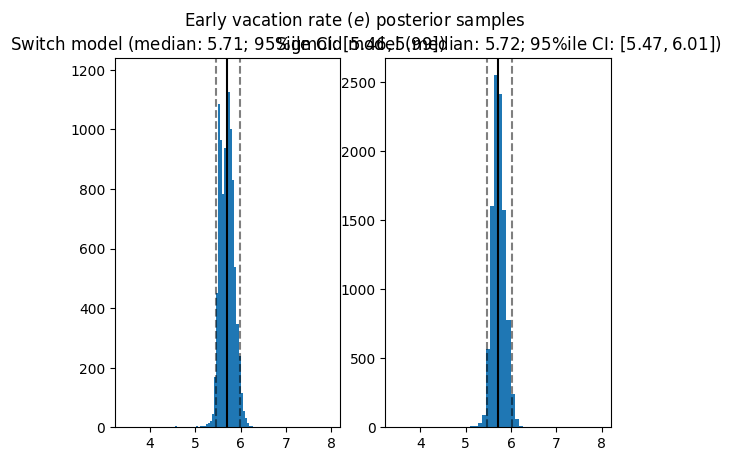

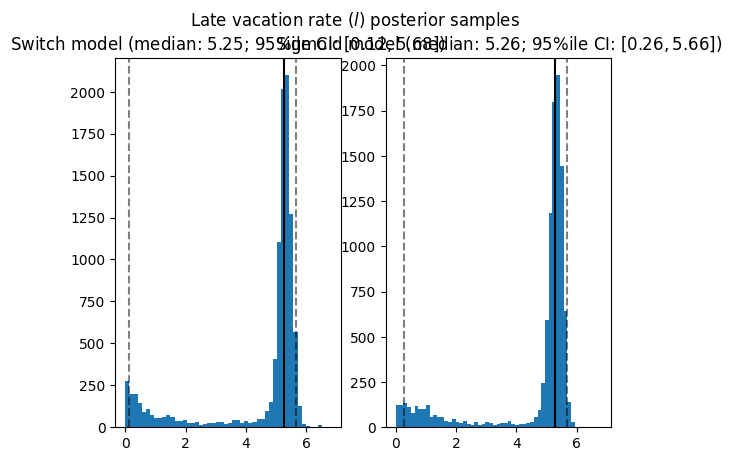

UFuncTypeError: ufunc 'multiply' cannot use operands with types dtype('<M8[s]') and dtype('float64')

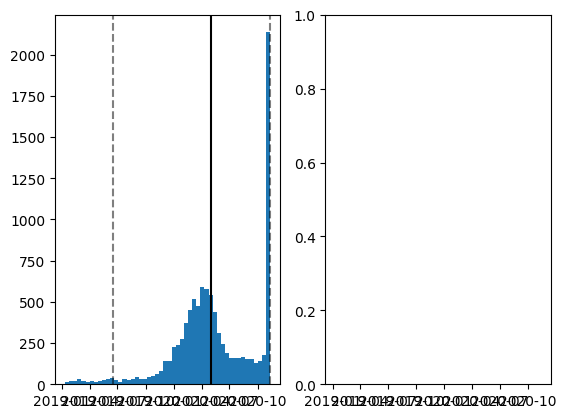

In [87]:
def _desc(v):
  return '(median: {}; 95%ile CI: $[{}, {}]$)'.format(
      *np.round(np.percentile(v, [50, 2.5, 97.5]), 2))

for t, v in [
    ('Early vacation rate ($e$) posterior samples', early_vacation_rate),
    ('Late vacation rate ($l$) posterior samples', late_vacation_rate),
    ('Switch point ($s$) posterior samples', vacation_dates[0] + switchpoint_2),
]:
  fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True)
  for (m, i) in (('Switch', 0), ('Sigmoid', 1)):
    a = ax[i]
    a.hist(v[i], bins=50)
    a.axvline(x=np.percentile(v[i], 50), color='k')
    a.axvline(x=np.percentile(v[i], 2.5), color='k', ls='dashed', alpha=.5)
    a.axvline(x=np.percentile(v[i], 97.5), color='k', ls='dashed', alpha=.5)
    a.set_title(m + ' model ' + _desc(v[i]))
  fig.suptitle(t)
  plt.show()

In [54]:
# Break point
print(np.exp(5.25))
print(np.exp(5.74))
print(np.exp(5.25)-np.exp(5.74))

204.38388199296807
311.06441098139294
-106.68052898842487


In [88]:
# Sigmoid point
print(np.exp(5.26))
print(np.exp(5.72))
print(np.exp(5.26) - np.exp(5.72))

192.4814912972456
304.90492295690854
-112.42343165966292


# Conclusion
- We tend to have a rate of average - 106 vacation search after covid than before
- The switch point is around March 2020 but the 95 percent credible interval is quite large and span from late 2019 to october 2020 so drawing a conclusion about it is tricky although increasing the burning rate seems to reduce the credible interval.